# Project 5B: Flow Matching from Scratch!

## Setup environment

In [ ]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00


In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Neural Network Resources

In this part, you will build and train a [UNet](https://arxiv.org/abs/1505.04597), which is more complex than the MLP you implemented in the NeRF project.  We provide all class definitions you may need (but feel free to add or modify them as necessary).  

Instead of asking ChatGPT to write everything for you, please consult the following resources when you get stuck — they will help you understand how and why things work under the hood.

- PyTorch Documentation — [`Conv2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [`ConvTranspose2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html), and [`AvgPool2d`](https://docs.pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html).
- PyTorch Documentation - [`torchvision.datasets.MNIST`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html), the dataset we gonna use, and [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html), the off-the-shell dataloader we can directly use.
- PyTorch [tutorial](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) on how to train a classifier on CIFAR10 dataset. The structure of your training code will be very similar to this one.

# Part 1: Training a Single-step Denoising UNet


# Part 1.1: Implementing the UNet

## Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # these params should: "not change the image resolution, only the channel dimension."
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # same as Conv but params are (3,2,1) -> downsamples by 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # (4,2,1) -> upsamples by 2
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

        # flattens 7x7 region into 1x1
        self.pool = nn.AvgPool2d(kernel_size=7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pool(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)

        return x



class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.downconv = DownConv(in_channels, out_channels) # down samples by 2
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downconv(x)
        x = self.convblock(x)

        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.upconv = UpConv(in_channels, out_channels)
        self.convblock = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        x = self.convblock(x)

        return x

## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.convblock1 = ConvBlock(in_channels, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten1 = Flatten()
        self.unflatten1 = Unflatten(num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x_1 = self.convblock1.forward(x)
        x_2 = self.downblock1.forward(x_1)
        x_3 = self.downblock2.forward(x_2)
        x_4 = self.flatten1.forward(x_3)
        x_5 = self.unflatten1.forward(x_4)
        x_6 = torch.cat([x_5, x_3], dim=1)
        x_7 = self.upblock1.forward(x_6)
        x_8 = torch.cat([x_7, x_2], dim=1)
        x_9 = self.upblock2.forward(x_8)
        x_10 = torch.cat([x_9, x_1], dim=1)
        x_11 = self.convblock2.forward(x_10)

        output = self.out_conv(x_11)

        return output

# Part 1.2: Using the UNet to Train a Denoiser

In [ ]:
train_dataset = MNIST(root='./sample_data', train=True, download=True, transform=ToTensor())
x = train_dataset.__getitem__(0)[0]

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 538kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]


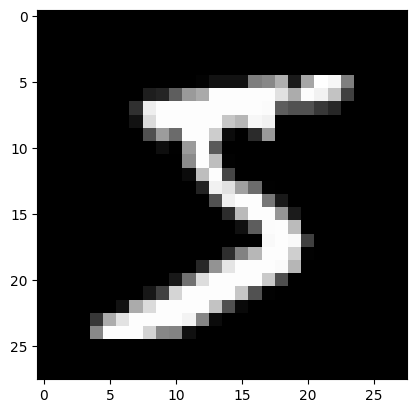

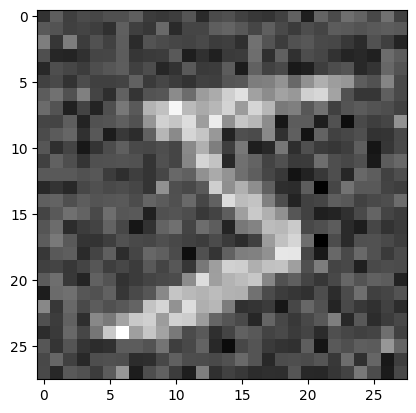

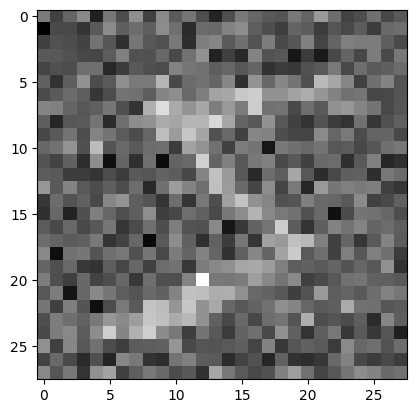

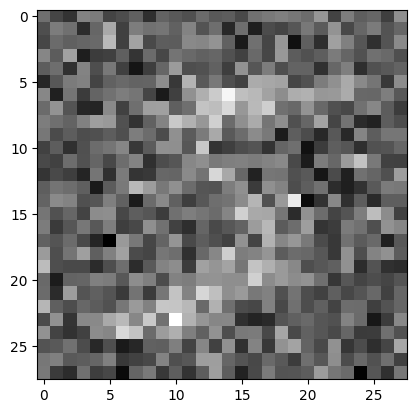

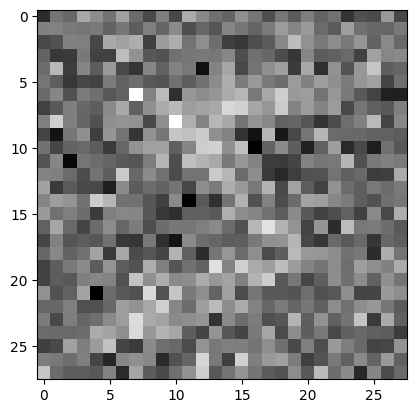

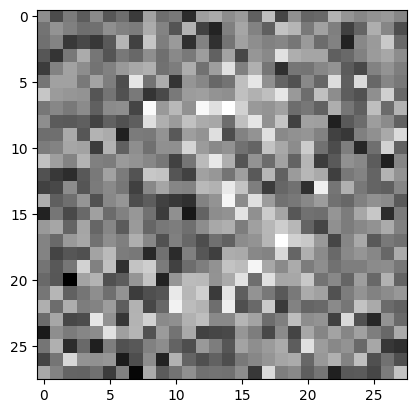

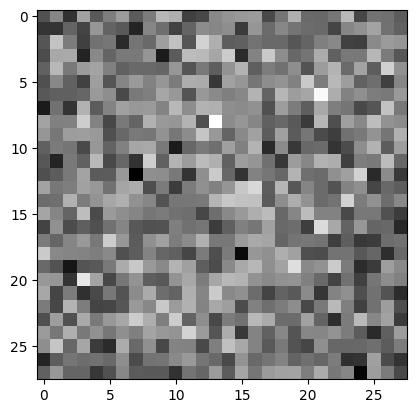

In [ ]:
# Visualize images at different noisy level

sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
for i in range(len(sigmas)):
    sigma = sigmas[i]
    z = x + sigma * torch.randn_like(x)
    plt.imshow(z[0], cmap='gray')
    plt.show()
    plt.imsave(f'/content/drive/MyDrive/noisy_image_{i}.png', z[0], cmap='gray')


## Part 1.2.1: Training

For this part, we provide some structure code for training. It is very basic, so feel free to change them or add your code. In later section we won't provide any training or visualization structure code.

In [ ]:
device = torch.device('cuda')

# Set your hyperparameters
# ===== your code here! ====
batch_size = 256
learning_rate = 1e-4
noise_level = 0.5
hidden_dim = 128
num_epochs = 5
# ===== end of code ====

In [ ]:
# Define datasets and dataloaders
train_dataset = train_dataset
test_dataset = MNIST(root='./sample_data', train=False, download=True, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Define model, optimizer, and loss

model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
@torch.no_grad()
def generate_samples1(model, epoch):
    model.eval()

    test_ex1 = test_dataset.__getitem__(0)[0].to(device)
    test_ex2 = test_dataset.__getitem__(1)[0].to(device)
    test_ex3 = test_dataset.__getitem__(2)[0].to(device)

    noise1 = torch.randn_like(test_ex1) * noise_level
    noise2 = torch.randn_like(test_ex2) * noise_level
    noise3 = torch.randn_like(test_ex3) * noise_level

    input1 = test_ex1 + noise1
    input2 = test_ex2 + noise2
    input3 = test_ex3 + noise3


    test_res1 = model(input1.unsqueeze(0))
    test_res2 = model(input2.unsqueeze(0))
    test_res3 = model(input3.unsqueeze(0))

    plt.imsave(f'/content/drive/MyDrive/test_nonpure1_epoch{epoch}.png', test_res1[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_nonpure2_epoch{epoch}.png', test_res2[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_nonpure3_epoch{epoch}.png', test_res3[0,0].cpu().detach().numpy(), cmap='gray')

    model.train()

In [ ]:
# The training loops
train_losses = []
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        # ===== your code here! ====

        images = images.to(device)
        noise = torch.randn_like(images) * noise_level
        noise = noise.to(device)
        images_noisy = images + noise

        outputs = model(images_noisy)

        # ===== end of code ====

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if epoch == 1:
        generate_samples1(model, epoch)

generate_samples1(model, num_epochs)

torch.save(model.state_dict(), "/content/drive/MyDrive/unet_mnist.pth")

100%|██████████| 235/235 [01:32<00:00,  2.54it/s]


In [ ]:
#model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
#model.load_state_dict(torch.load("unet_mnist.pth", map_location=device))
model.eval()

test_ex1 = test_dataset.__getitem__(0)[0].to(device)
test_ex2 = test_dataset.__getitem__(1)[0].to(device)
test_ex3 = test_dataset.__getitem__(2)[0].to(device)

test_ex1_noisy = test_ex1 + noise_level * torch.randn_like(test_ex1)
test_ex2_noisy = test_ex2 + noise_level * torch.randn_like(test_ex2)
test_ex3_noisy = test_ex3 + noise_level * torch.randn_like(test_ex3)

model.eval()
with torch.no_grad():
    test_res1 = model(test_ex1_noisy.unsqueeze(0))
    test_res2 = model(test_ex2_noisy.unsqueeze(0))
    test_res3 = model(test_ex3_noisy.unsqueeze(0))

plt.imsave('/content/drive/MyDrive/test_ex1_noisy.png', test_ex1_noisy[0].cpu(), cmap='gray')
plt.imsave('/content/drive/MyDrive/test_ex2_noisy.png', test_ex2_noisy[0].cpu(), cmap='gray')
plt.imsave('/content/drive/MyDrive/test_ex3_noisy.png', test_ex3_noisy[0].cpu(), cmap='gray')

plt.imsave('/content/drive/MyDrive/test_res1.png', test_res1[0,0].cpu().detach().numpy(), cmap='gray')
plt.imsave('/content/drive/MyDrive/test_res2.png', test_res2[0,0].cpu().detach().numpy(), cmap='gray')
plt.imsave('/content/drive/MyDrive/test_res3.png', test_res3[0,0].cpu().detach().numpy(), cmap='gray')

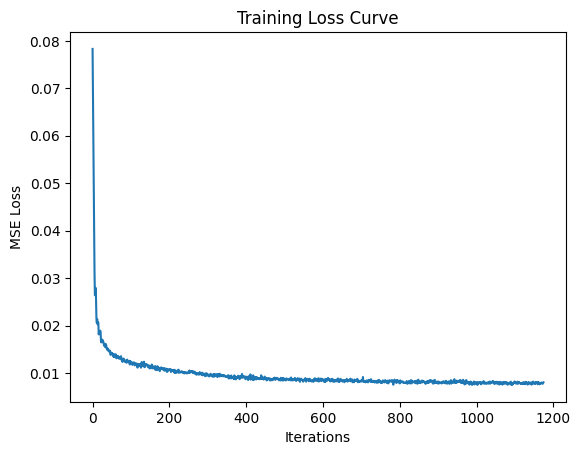

In [ ]:
# Visualize training curve
plt.plot(train_losses)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.savefig('/content/drive/MyDrive/training_curve.png')
plt.show()



## Part 1.2.2: Out-of-Distribution Testing

In [ ]:
# Visualize OOD testing

#model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/unet_mnist.pth", map_location=device))
model.eval()

test_sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
for i in range(len(test_sigmas)):
    sigma = test_sigmas[i]

    test_ex1 = test_dataset.__getitem__(0)[0].to(device)
    test_ex2 = test_dataset.__getitem__(1)[0].to(device)
    test_ex3 = test_dataset.__getitem__(2)[0].to(device)

    test_ex1_noisy = test_ex1 + sigma * torch.randn_like(test_ex1)
    test_ex2_noisy = test_ex2 + sigma * torch.randn_like(test_ex2)
    test_ex3_noisy = test_ex3 + sigma * torch.randn_like(test_ex3)

    model.eval()
    with torch.no_grad():
        test_res1 = model(test_ex1_noisy.unsqueeze(0))
        test_res2 = model(test_ex2_noisy.unsqueeze(0))
        test_res3 = model(test_ex3_noisy.unsqueeze(0))

    plt.imsave(f'/content/drive/MyDrive/test_oodt1_{i}.png', test_res1[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_oodt2_{i}.png', test_res2[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_oodt3_{i}.png', test_res3[0,0].cpu().detach().numpy(), cmap='gray')




## Part 1.2.3 Denoising Pure Noise

In [ ]:
@torch.no_grad()
def generate_samples2(model, epoch):
    test_ex1 = test_dataset.__getitem__(0)[0].to(device)
    test_ex2 = test_dataset.__getitem__(1)[0].to(device)
    test_ex3 = test_dataset.__getitem__(2)[0].to(device)

    input1 = torch.randn_like(test_ex1)
    input2 = torch.randn_like(test_ex2)
    input3 = torch.randn_like(test_ex3)

    model.eval()

    test_res1 = model(input1.unsqueeze(0))
    test_res2 = model(input2.unsqueeze(0))
    test_res3 = model(input3.unsqueeze(0))

    plt.imsave(f'/content/drive/MyDrive/test_pure1_epoch{epoch}.png', test_res1[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_pure2_epoch{epoch}.png', test_res2[0,0].cpu().detach().numpy(), cmap='gray')
    plt.imsave(f'/content/drive/MyDrive/test_pure3_epoch{epoch}.png', test_res3[0,0].cpu().detach().numpy(), cmap='gray')


In [ ]:
model = UnconditionalUNet(in_channels=1, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_losses = []
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        images = images.to(device)
        noise = torch.randn_like(images)
        noise = noise.to(device)

        outputs = model(noise)

        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if epoch == 1:
        generate_samples(model, epoch)

generate_samples(model, num_epochs)
torch.save(model.state_dict(), "unet_mnist.pth")

100%|██████████| 235/235 [01:35<00:00,  2.47it/s]


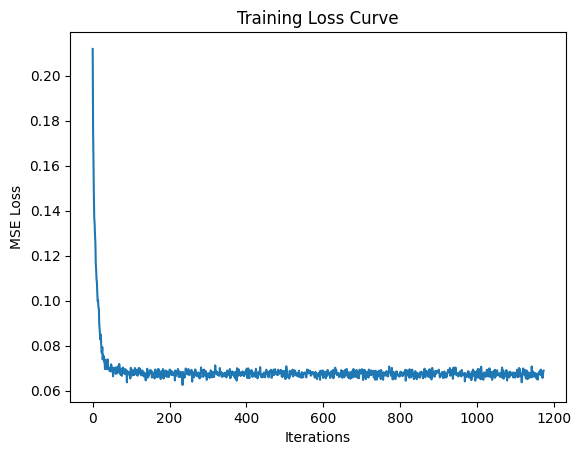

In [ ]:
plt.plot(train_losses)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.savefig('/content/drive/MyDrive/training_curve2.png')
plt.show()

# Part 2: Flow Matching

# Part 2.1: Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.lin1 = nn.Linear(in_channels, out_channels)
        self.activation = nn.GELU()
        self.lin2 = nn.Linear(out_channels, out_channels)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)

        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.convblock1 = ConvBlock(in_channels, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten1 = Flatten()
        self.unflatten1 = Unflatten(num_hiddens * 2)

        self.fcblock1 = FCBlock(1, num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.fcblock2 = FCBlock(1, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        batch_size = x.shape[0]

        t = t.unsqueeze(1)
        t = t.to(device).float()

        x_1 = self.convblock1.forward(x)
        x_2 = self.downblock1.forward(x_1)
        x_3 = self.downblock2.forward(x_2)
        x_4 = self.flatten1.forward(x_3)

        x_5 = self.unflatten1.forward(x_4)
        t1 = self.fcblock1.forward(t)
        t1 = t1.view(batch_size, -1, 1, 1)
        x_5 = x_5 * t1

        x_6 = torch.cat([x_5, x_3], dim=1)

        x_7 = self.upblock1.forward(x_6)
        t2 = self.fcblock2.forward(t)
        t2 = t2.view(batch_size, -1, 1, 1)
        x_7 = x_7 * t2

        x_8 = torch.cat([x_7, x_2], dim=1)
        x_9 = self.upblock2.forward(x_8)
        x_10 = torch.cat([x_9, x_1], dim=1)
        x_11 = self.convblock2.forward(x_10)

        output = self.out_conv(x_11)

        return output

## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [ ]:
def time_fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()

    device = x_1.device
    batch_size = x_1.shape[0]

    t = torch.randint(low=0, high=num_ts, size=(batch_size,), device=device)
    t = t.float() / num_ts #normalize
    t_li = t.view(batch_size, 1, 1, 1) # must reshape to match for linear interpolacao

    x_0 = torch.randn_like(x_1)

    x_t = (1-t_li) * x_0 + t_li * x_1 # linear interpolacao

    output = unet(x_t, t)

    loss = nn.MSELoss()(output, x_1 - x_0) # loss measured between output and true velocity field

    return loss


In [ ]:
@torch.inference_mode()
def time_fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    device = next(unet.parameters()).device
    torch.manual_seed(seed)

    h, w = img_wh

    x_t = torch.randn((1, 1, h, w)).to(device)

    for i in range(num_ts):
        t = torch.tensor([i / num_ts], device = device).float()
        t = t.to(device)

        x_t = x_t + (1.0 / num_ts) * unet(x_t, t) # Take a step in the direction/velocity output of unet

    return x_t


In [ ]:
class TimeConditionalFM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return time_fm_forward(
            self.unet, x, self.num_ts
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return time_fm_sample(
            self.unet, img_wh, self.num_ts, seed
        )


# Part 2.2: Training the Time-conditioned UNet

In [ ]:
"""
batch_size = 64
learning_rate = 1e-2
hidden_dim = 64
num_epochs = 10
model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1.0/num_epochs))
num_ts=100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_losses3 = []
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):

        images = images.to(device)
        loss = time_fm_forward(model, images, num_ts)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses3.append(loss.item())
    scheduler.step()

    if epoch == 0 or epoch == 4:
        torch.save(model.state_dict(), f"cnet_mnist_epoch{epoch+1}.pth")

torch.save(model.state_dict(), "cnet_mnist_epoch10.pth")"""

'\nbatch_size = 64\nlearning_rate = 1e-2\nhidden_dim = 64\nnum_epochs = 10\nmodel = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\nscheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1.0/num_epochs))\nnum_ts=100\n\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\n\ntrain_losses3 = []\nmodel.train()\nfor epoch in range(num_epochs):\n    for i, (images, _) in enumerate(tqdm(train_loader)):\n\n        images = images.to(device)\n        loss = time_fm_forward(model, images, num_ts)\n        \n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n        train_losses3.append(loss.item())\n    scheduler.step()\n\n    if epoch == 0 or epoch == 4:\n        torch.save(model.state_dict(), f"cnet_mnist_epoch{epoch+1}.pth")\n\ntorch.save(m

In [ ]:
batch_size = 64
learning_rate = 1e-2
hidden_dim = 128
num_epochs = 25
num_ts = 150

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
fm_model = TimeConditionalFM(model, num_ts=num_ts).to(device)

optimizer = torch.optim.Adam(fm_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1.0/num_epochs))

train_losses6 = []
fm_model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)

        loss = fm_model(images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses5.append(loss.item())
    scheduler.step()

    #if epoch == 0 or epoch == 4:
    #    torch.save(fm_model.state_dict(), f"time_fm_epoch{epoch+1}.pth")

torch.save(fm_model.state_dict(), "time_fm_epoch25.pth")

100%|██████████| 938/938 [01:46<00:00,  8.84it/s]


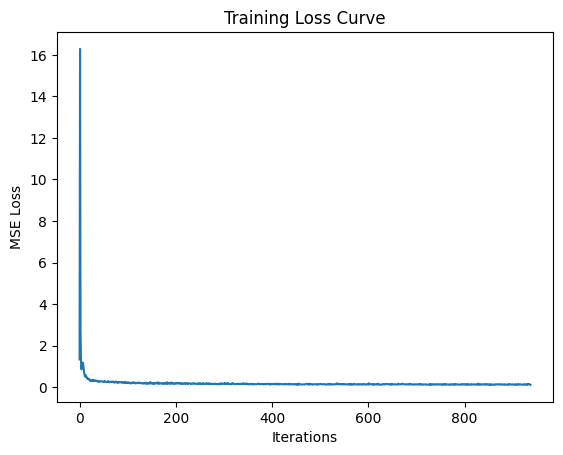

In [ ]:
plt.plot(train_losses6)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.savefig('/content/drive/MyDrive/improved_curve.png')
plt.show()

# Part 2.3: Sampling from the Time-conditioned UNet

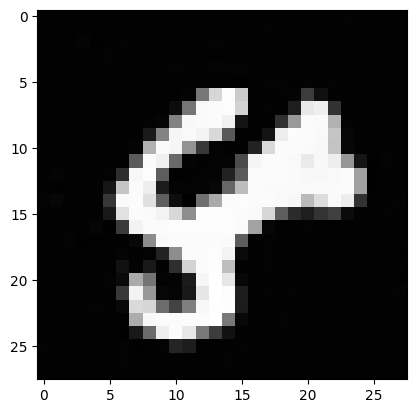

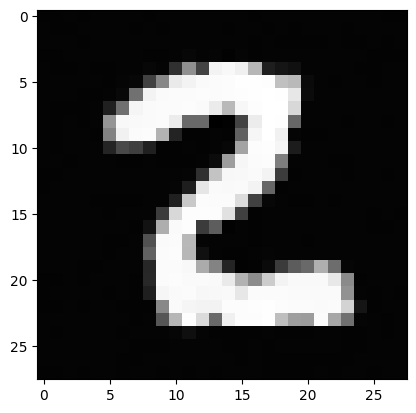

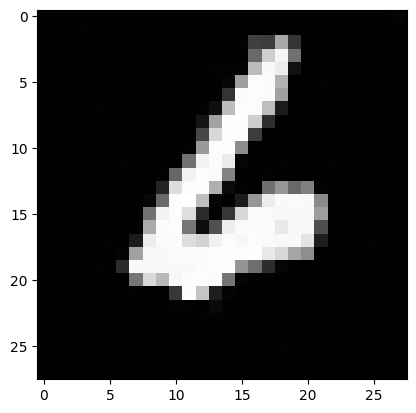

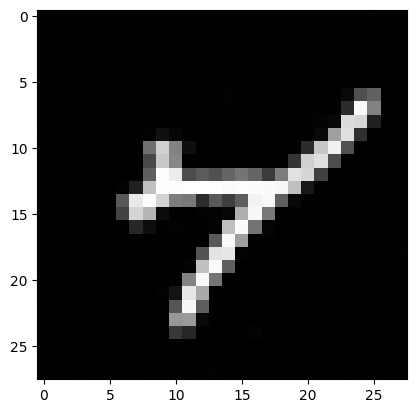

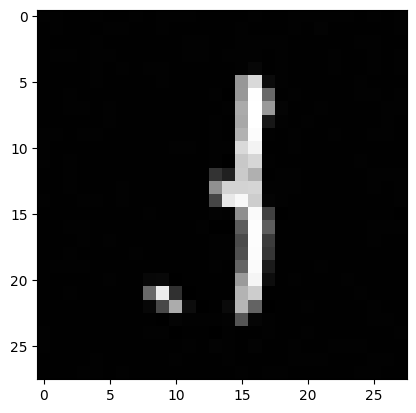

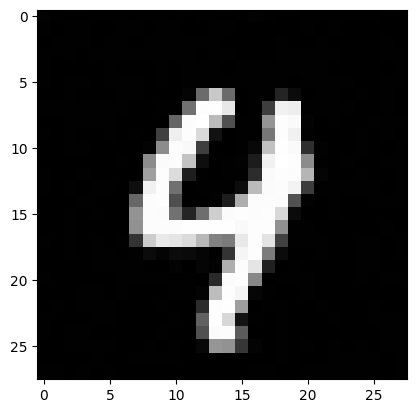

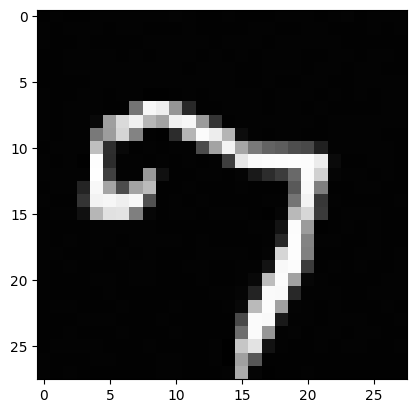

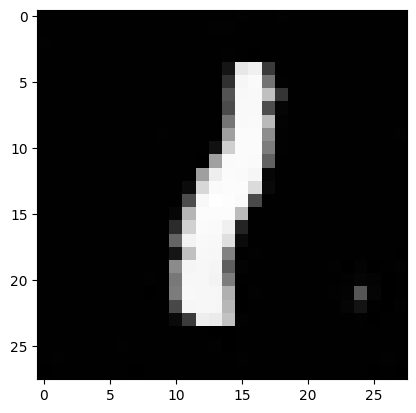

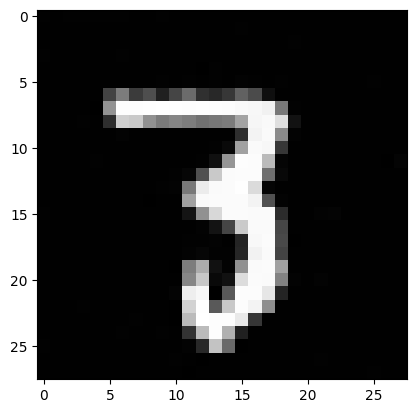

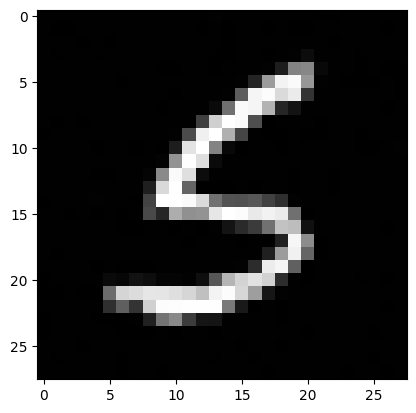

In [ ]:
tc_unet = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)

fm_model = TimeConditionalFM(tc_unet).to(device)
fm_model.load_state_dict(torch.load("time_fm_epoch25.pth", map_location=device))
fm_model.eval()


for i in range(10): # 10 samples
    x_t = fm_model.sample(img_wh=(28, 28), seed=i)
    x_t = x_t[:,0][0].cpu().numpy()

    plt.imshow(x_t, cmap="gray")
    plt.show()

    plt.imsave(f'/content/drive/MyDrive/tc_unet_25epochs_sample{i}.png', x_t, cmap='gray')

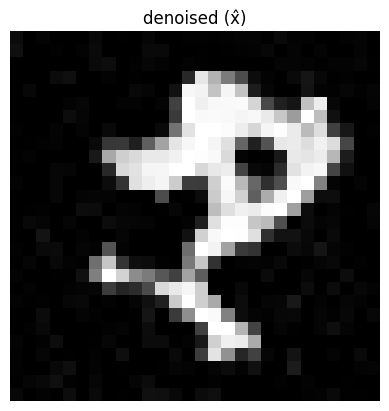

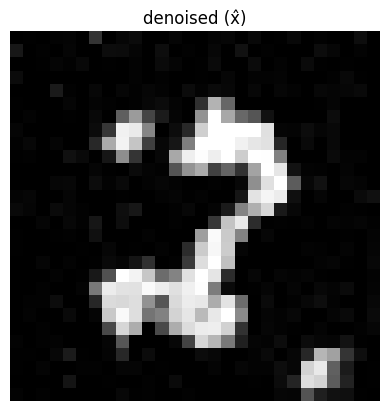

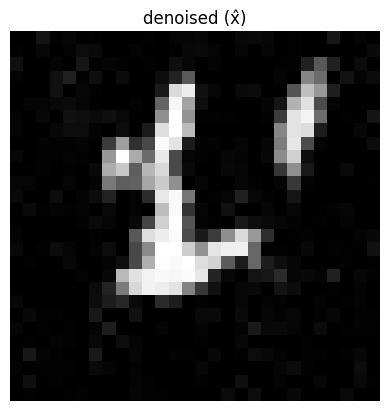

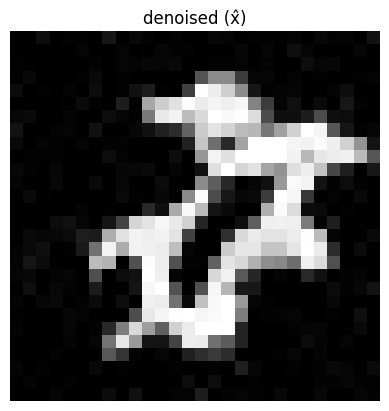

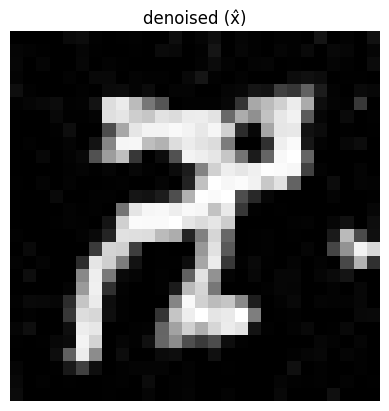

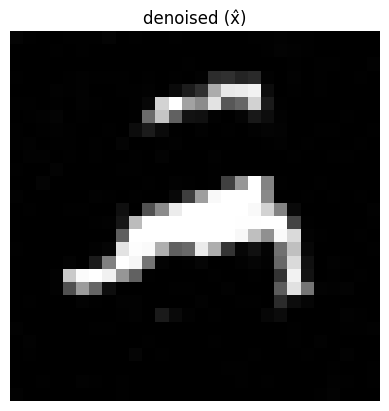

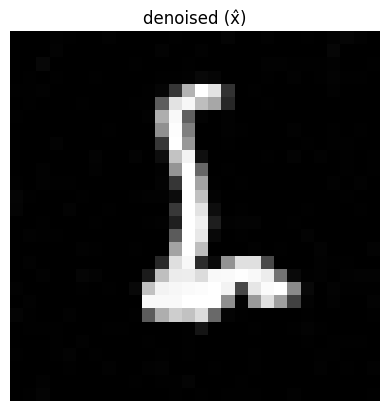

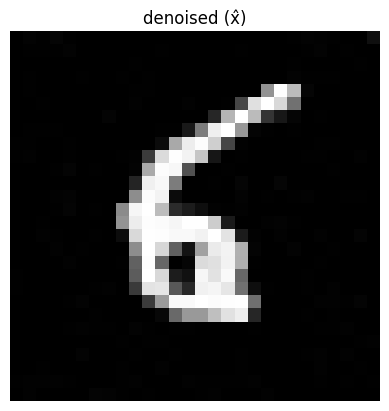

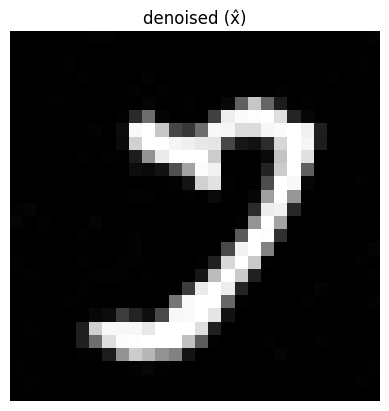

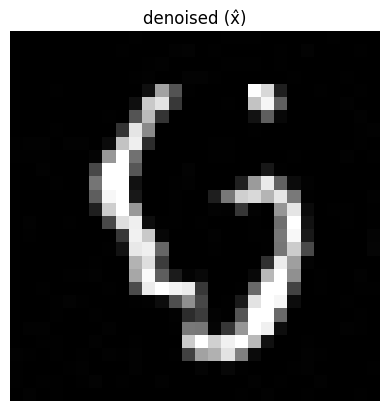

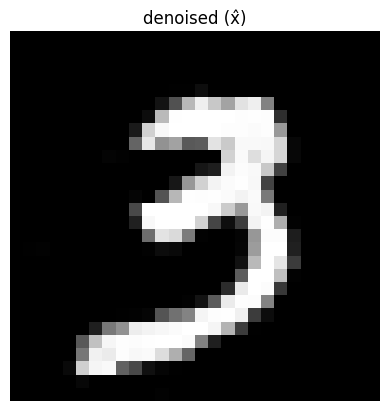

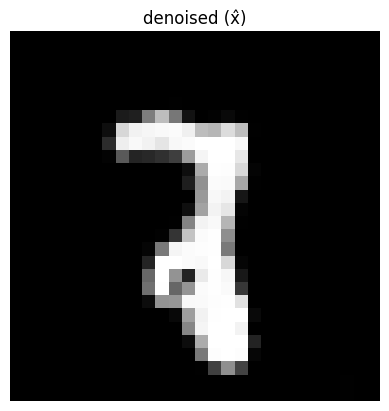

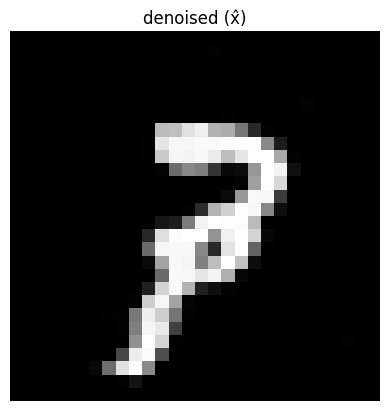

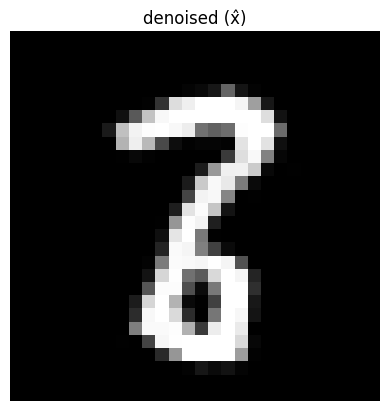

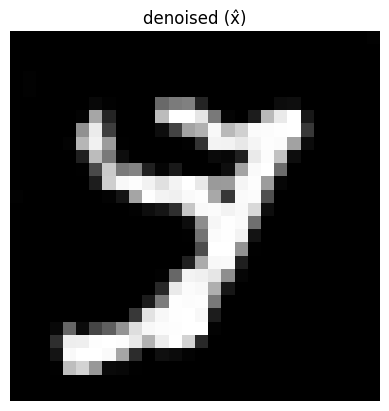

In [ ]:
# Sampling from the UNet
"""
model_epoch1 = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
model_epoch1.load_state_dict(torch.load("cnet_mnist_epoch1.pth", map_location=device))
model_epoch1.eval()

model_epoch5 = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
model_epoch5.load_state_dict(torch.load("cnet_mnist_epoch5.pth", map_location=device))
model_epoch5.eval()

model_epoch10 = TimeConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
model_epoch10.load_state_dict(torch.load("cnet_mnist_epoch10.pth", map_location=device))
model_epoch10.eval()

def sample(tc_unet: TimeConditionalUNet, num_ts):
    x_t = torch.randn((1, 1, 28, 28)).to(device)

    with torch.no_grad():
        for i in range(num_ts):
            t = torch.tensor([i / num_ts], device = device).float()
            t = t.to(device)

            x_t = x_t + (1.0 / num_ts) * tc_unet(x_t, t) # Take a step in the direction/velocity output of unet

    return x_t

def show(img, title):
    plt.imshow(img.squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.axis("off")

for i in range(5): # 5 samples
    x_t = sample(model_epoch1, num_ts)
    show(x_t, "denoised (x̂)")
    plt.show()

    plt.imsave(f'/content/drive/MyDrive/test_pure{i}_epoch1.png', x_t[0,0].cpu().detach().numpy(), cmap='gray')

for i in range(5): # 5 samples
    x_t = sample(model_epoch5, num_ts)
    show(x_t, "denoised (x̂)")
    plt.show()

    plt.imsave(f'/content/drive/MyDrive/test_pure{i}_epoch5.png', x_t[0,0].cpu().detach().numpy(), cmap='gray')

for i in range(5): # 5 samples
    x_t = sample(model_epoch10, num_ts)
    show(x_t, "denoised (x̂)")
    plt.show()

    plt.imsave(f'/content/drive/MyDrive/test_pure{i}_epoch10.png', x_t[0,0].cpu().detach().numpy(), cmap='gray') """


# Part 2.4: Implementing a Class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()

        self.num_classes = num_classes

        ### new
        self.fc_c1 = FCBlock(num_classes, num_hiddens * 2)
        self.fc_c2 = FCBlock(num_classes, num_hiddens)

        self.convblock1 = ConvBlock(in_channels, num_hiddens)

        self.downblock1 = DownBlock(num_hiddens, num_hiddens)
        self.downblock2 = DownBlock(num_hiddens, num_hiddens * 2)

        self.flatten1 = Flatten()
        self.unflatten1 = Unflatten(num_hiddens * 2)

        self.fcblock1 = FCBlock(1, num_hiddens * 2)

        self.upblock1 = UpBlock(num_hiddens * 4, num_hiddens)
        self.fcblock2 = FCBlock(1, num_hiddens)
        self.upblock2 = UpBlock(num_hiddens * 2, num_hiddens)

        self.convblock2 = ConvBlock(num_hiddens * 2, num_hiddens)

        self.out_conv = nn.Conv2d(in_channels=num_hiddens, out_channels=in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        batch_size = x.shape[0]
        device = x.device

        #### one hot encoding c
        c = F.one_hot(c.to(device), num_classes=self.num_classes).float()

        if mask is not None: # used in sampling
            m = mask.float().view(batch_size, 1).to(device).float()
            c = c * m

        t = t.unsqueeze(1)
        t = t.to(device).float()

        x_1 = self.convblock1.forward(x)
        x_2 = self.downblock1.forward(x_1)
        x_3 = self.downblock2.forward(x_2)
        x_4 = self.flatten1.forward(x_3)

        ##### Adding in class
        c1 = self.fc_c1.forward(c.float())
        c1 = c1.view(batch_size, -1, 1, 1)

        x_5 = self.unflatten1.forward(x_4)

        t1 = self.fcblock1.forward(t)
        t1 = t1.view(batch_size, -1, 1, 1)
        x_5 = c1 * x_5 + t1

        x_6 = torch.cat([x_5, x_3], dim=1)

        c2 = self.fc_c2.forward(c.float())
        c2 = c2.view(batch_size, -1, 1, 1)

        x_7 = self.upblock1.forward(x_6)
        t2 = self.fcblock2.forward(t)
        t2 = t2.view(batch_size, -1, 1, 1)
        x_7 = c2 * x_7 + t2

        x_8 = torch.cat([x_7, x_2], dim=1)
        x_9 = self.upblock2.forward(x_8)
        x_10 = torch.cat([x_9, x_1], dim=1)
        x_11 = self.convblock2.forward(x_10)

        output = self.out_conv(x_11)

        return output

In [ ]:
def class_fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """

    unet.train()

    batch_size = x_1.shape[0]
    device = x_1.device

    t = torch.randint(low=0, high=num_ts, size=(batch_size,), device=device)
    t = t.float() / num_ts #normalize
    t = t.view(batch_size, 1, 1, 1)

    x_0 = torch.randn_like(x_1)

    x_t = (1-t) * x_0 + t * x_1 # linear interpolacao

    drop_mask = 1.0 - (torch.rand(batch_size, device=device) < p_uncond).float() #drop 10% of each batch

    output = unet(x_t, c, t, drop_mask)

    loss = nn.MSELoss()(output, x_1 - x_0) # loss measured between output and true velocity field

    return loss

In [ ]:
@torch.inference_mode()
def class_fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """

    unet.eval()

    device = next(unet.parameters()).device
    torch.manual_seed(seed)
    batch_size = c.shape[0]
    h, w = img_wh

    num_channels = unet.out_conv.out_channels
    x_t = torch.randn((batch_size, num_channels, h, w)).to(device)

    for i in range(num_ts):
        t = torch.full((batch_size,), i / num_ts, device = device).float()

        mask_uncond = torch.zeros(batch_size, device=device)
        mask_cond = torch.ones(batch_size, device=device)

        velocity_uncond = unet(x_t, c, t, mask_uncond)
        velocity_cond = unet(x_t, c, t, mask_cond)

        velocity_cfg = velocity_uncond + guidance_scale * (velocity_cond - velocity_uncond)

        x_t = x_t + (1.0 / num_ts) * velocity_cfg

    return x_t

In [ ]:
class ClassConditionalFM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return class_fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return class_fm_sample(
            self.unet, c, img_wh, self.num_ts, guidance_scale, seed
        )

# Part 2.5 Training the Class-conditioned UNet

In [ ]:
# Feel free to use code from part 1.2.1
# as they should be very similar


batch_size = 64
learning_rate = 1e-3
hidden_dim = 64
num_epochs = 15
num_ts=100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)
fm_model = ClassConditionalFM(model, num_ts=num_ts, p_uncond=0.1).to(device)

optimizer = torch.optim.Adam(fm_model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.1**(1.0/num_epochs))

train_losses4 = []
for epoch in range(num_epochs):
    for images, labels in train_loader:

        images = images.to(device)
        labels = labels.to(device)

        loss = fm_model(images, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses4.append(loss.item())
    #scheduler.step()

    #if epoch == 0 or epoch == 4:
    #    torch.save(fm_model.state_dict(), f"cnet_class_mnist_epoch{epoch+1}.pth")

torch.save(fm_model.state_dict(), "test_fm_unet2.pth")

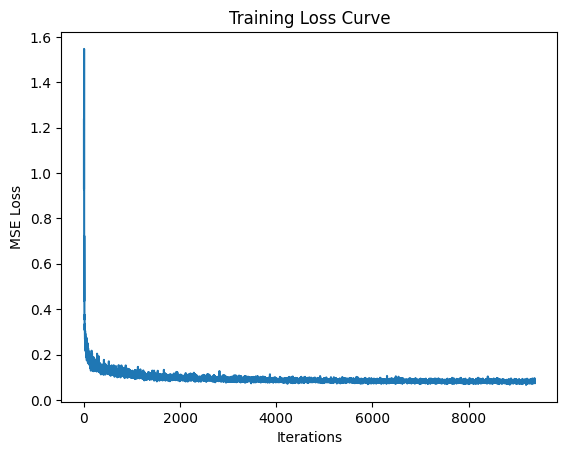

In [ ]:
plt.plot(train_losses4)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('Training Loss Curve')
plt.savefig('/content/drive/MyDrive/training_curve5.png')
plt.show()

# Part 2.6: Sampling from the Class-conditioned UNet

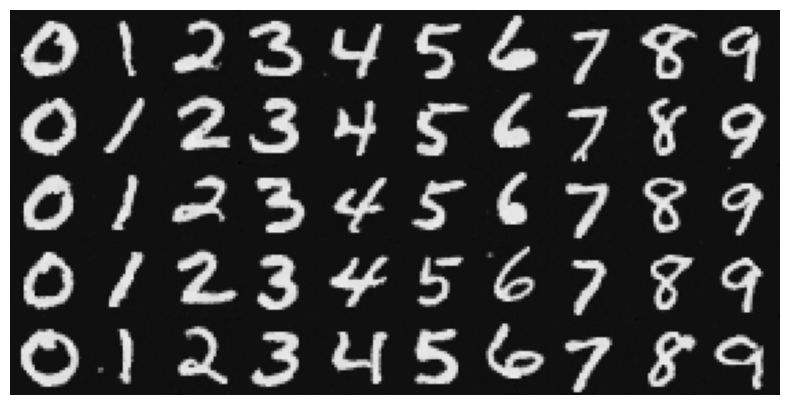

In [ ]:
# Sampling from the UNet

unet = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=hidden_dim).to(device)

"""
model1 = ClassConditionalFM(unet).to(device)
model1.load_state_dict(torch.load("cnet_class_mnist_epoch1.pth", map_location=device))
model1.eval()


model5 = ClassConditionalFM(unet).to(device)
model5.load_state_dict(torch.load("cnet_class_mnist_epoch5.pth", map_location=device))
model5.eval()

"""
model10 = ClassConditionalFM(unet).to(device)
model10.load_state_dict(torch.load("test_fm_unet2.pth", map_location=device))
model10.eval()

digits = torch.repeat_interleave(torch.arange(10, device=device), repeats=5) # creates a sample per class x 5 (5x10)
samples = model10.sample(c=digits, img_wh=(28, 28), guidance_scale=5.0, seed=0)

samples = samples[:,0].cpu() # (50, 28, 28)

columns = []
for d in range(10):
    col_imgs = [samples[5*d + r] for r in range(5)]
    col = torch.cat(col_imgs, dim=0)
    columns.append(col)

big_image = torch.cat(columns, dim=1)

plt.figure(figsize=(12, 5))
plt.imshow(big_image, cmap="gray")
plt.axis("off")
plt.show()

plt.imsave("/content/drive/MyDrive/5x10_samples_test2.png", big_image.numpy(), cmap="gray")



